In [1]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../..')
sys.path.insert(0, '../../../..')
sys.path.insert(0, '../../../../..')

from deviation_prediction.deviation import Deviation
from evaluation.evalaution_metrics import EvaluationMetrics

In [2]:
# Get results from the processed inference/ test dataset storing two dicts: 
# One containing all suffixes with mean samller than Mean-threshold.
# One containing all suffixes with mean samller than Q0.9-threshold.

output_dir   = '../../../../../../data/Helpdesk/conformal_prediction_gn_l4'

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

filename = os.path.join(output_dir, 'risk_inference_set.pkl')
with open(filename, 'rb') as f:
    loaded_results_risk = pickle.load(f)
print(f"Loaded data from {filename}")

Loaded data from ../../../../../../data/Helpdesk/conformal_prediction_gn_l4/risk_inference_set.pkl


In [3]:
# grab the list of all metric‐names from the first entry
fields_risk = list(loaded_results_risk[next(iter(loaded_results_risk))].keys())

# build the “pivoted” dict of dicts
seperate_dict_risk = {field: { prefix: subdict[field] for prefix, subdict in loaded_results_risk.items() } for field in fields_risk}

In [4]:
# test_case_value = seperate_dict_risk['test_case_value']

Means:  [0.66595735 0.74880336 0.73854408 0.65029486 0.60555524 0.60962082
 0.56857804 0.59059307]
SDs:  [0.12375006 0.10272765 0.08725362 0.06821535 0.05094996 0.04297527
 0.04236937 0.02899605]
Uncertainties:  [18.58228063 13.71890925 11.81427437 10.4899113   8.41375894  7.04950787
  7.4518126   4.90964936]
Certainties:  [81.41771937 86.28109075 88.18572563 89.5100887  91.58624106 92.95049213
 92.5481874  95.09035064]


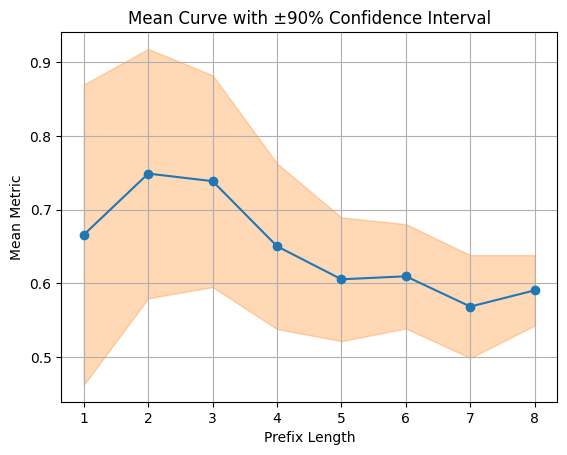

In [5]:
mean_samples_fitness_risk = seperate_dict_risk['mean_samples_fitness']
sd_samples_fitness_risk = seperate_dict_risk['sd_samples_fitness']

# Sort by prefix length
prefix = np.array(sorted(mean_samples_fitness_risk.keys()))
means  = np.array([np.mean(mean_samples_fitness_risk[k]) for k in prefix])
print("Means: ", means)

sds    = np.array([np.mean(sd_samples_fitness_risk[k]) for k in prefix])
print("SDs: ", sds)

uncertainties = np.array([sd/mean *100 for mean, sd in zip(means, sds)])
print("Uncertainties: ", uncertainties)

certainty = np.array([100-(sd/mean*100) for mean, sd in zip(means, sds)])
print("Certainties: ", certainty)

# 90% CI using z ≈ 1.645
z90 = 1.645

# Std within (fitness scores of T MC-Samples)-band: Probabilistic Suffix Prediction Fitness Score standard deviation:
lower_psp = means - z90 * sds
upper_psp = means + z90* sds


plt.figure()
plt.plot(prefix, means, marker='o', label='Mean Means Samples below Threshold', color='C0')
plt.fill_between(prefix, lower_psp, upper_psp, alpha=0.3, color='C1', label='Predictive Total Uncertainty')
plt.xlabel('Prefix Length')
plt.ylabel('Mean Metric')
plt.title('Mean Curve with ±90% Confidence Interval')
plt.grid(True)
plt.show()

In [6]:
target_conformance_risk = seperate_dict_risk['target_conformance']
most_likely_conformance_risk = seperate_dict_risk['most_likely_conformance']
# dict: prefix_length: list of list where mean fitness score smaller than threshold: 1000 MC samples with: 'sampled case', 'alignment', 'cost', 'fitness' 
samples_conformance_risk = seperate_dict_risk['samples_conformance']

In [7]:
dev_obj = Deviation()

# dict: pref_len, dict: model_moves: list of list, with tuples containing moves, log_moves: list of list, with tuples containing moves. 
deviations_target_risk = dev_obj.individual_deviations_target(target_conformance=target_conformance_risk)

deviations_most_likely = dev_obj.individual_deviations_most_likely(most_likely_conformance=most_likely_conformance_risk)

deviations_samples_risk = dev_obj.individual_deviations_samples(samples_conformance=samples_conformance_risk, beta_threshold=0.5)

In [8]:
# Compute Precision, Recall for each prefix length:
eval_obj = EvaluationMetrics(target_alignments=deviations_target_risk, predicted_alignments=deviations_samples_risk)

#  Measures how often the model is correct when it predicts a deviation.
precision_dev = eval_obj.precision_deviation()

# 
recall_dev = eval_obj.recall_deviation()

auc_roc_score, auc_roc_curve = eval_obj.auc_roc_deviation()


In [9]:
print("Precision Results:", precision_dev)
print("Total Precision: ", np.mean(list(precision_dev.values())))

print("Recall Results: ", recall_dev)
print("Total Recall: ", np.mean(list(recall_dev.values())))

print("AUC ROC: ", auc_roc_score)


Precision Results: OrderedDict({1: 1.0, 2: 0.8695652173913043, 3: 0.8235294117647058, 4: 0.8695652173913043, 5: 0.8, 6: 1.0, 7: 1.0, 8: 1.0})
Total Precision:  0.9203324808184143
Recall Results:  OrderedDict({1: 0.3064516129032258, 2: 0.3125, 3: 0.24561403508771928, 4: 0.5882352941176471, 5: 0.5333333333333333, 6: 0.6666666666666666, 7: 0.3333333333333333, 8: 0.3333333333333333})
Total Recall:  0.4149334510969074
AUC ROC:  0.7675159235668789


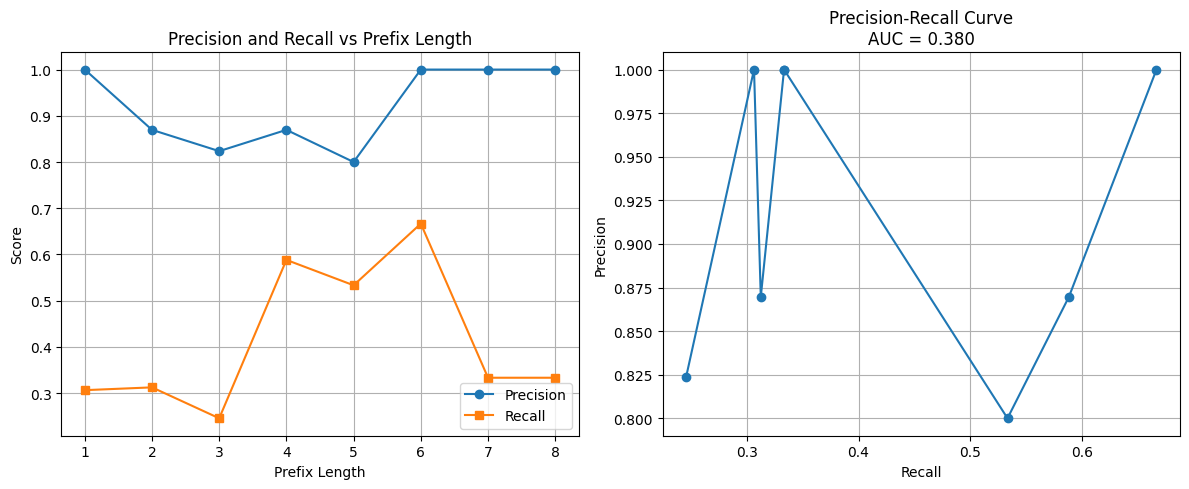

In [10]:
# === Plotting ===
prefix = np.array(list(precision_dev.keys()))
prec = np.array(list(precision_dev.values()))
rec = np.array(list(recall_dev.values()))
idx = np.argsort(rec)

pr_auc = eval_obj.auc_pr_deviation(precision_dev=precision_dev, recall_dev=recall_dev)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Precision vs Recall vs Prefix
ax1.plot(prefix, prec, marker='o')
ax1.plot(prefix, rec, marker='s')
ax1.set_xlabel('Prefix Length')
ax1.set_ylabel('Score')
ax1.set_title('Precision and Recall vs Prefix Length')
ax1.legend(['Precision', 'Recall'])
ax1.grid(True)

# PR Curve
ax2.plot(rec[idx], prec[idx], marker='o')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title(f'Precision-Recall Curve\nAUC = {pr_auc:.3f}')
ax2.grid(True)

plt.tight_layout()
plt.show()
